In [2]:
import torch
from matplotlib import pyplot as plt
from models.cnp import CNP
from models.wta_cnp import WTA_CNP

In [3]:
root_path = "/home/yigit/projects/mbcnp/outputs/sines/"
run_id, model_folder = '1692535146', '/saved_models/'
models_path = f'{root_path}{run_id}{model_folder}'

cnp_model_path, wta_model_path = f'{models_path}cnp_on_synth.pt', f'{models_path}wta_on_synth.pt'

torch.Size([4, 200, 1])


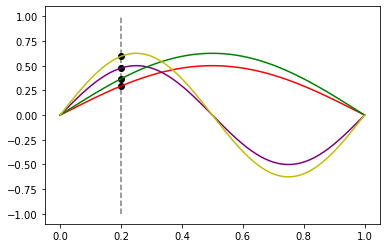

In [8]:
y = torch.load(f'{root_path}{run_id}/y.pt')[:4]
num_samples = y.shape[0]
print(y.shape)

x = torch.linspace(0, 1, 200).repeat(num_samples, 1).view(num_samples, -1, 1)
colors = ['r', 'purple', 'g', 'y']

test_ind = 40

for i in range(num_samples):
    plt.plot(x[i, :, 0].cpu(), y[i, :, 0].cpu(), colors[i%num_samples])
    plt.scatter(x[i, test_ind, 0], y[i, test_ind, 0], c='k')

test_x = x[0, test_ind, 0].item()

plt.plot([test_x]*200, torch.linspace(-1, 1, 200), 'k--', alpha=0.5)

In [9]:
batch_size = 4
cnp = CNP(input_dim=1, hidden_dim=158, output_dim=1, n_max_obs=10, n_max_tar=10, num_layers=3, batch_size=batch_size)
wta = WTA_CNP(1, 1, 10, 10, [128, 128, 128], num_decoders=2, decoder_hidden_dims=[128, 128, 128], batch_size=batch_size)

cnp.load_state_dict(torch.load(cnp_model_path))
wta.load_state_dict(torch.load(wta_model_path))

cnp.eval()
wta.eval()

WTA_CNP(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
  (decoders): ModuleList(
    (0-1): 2 x Sequential(
      (0): Linear(in_features=129, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=2, bias=True)
    )
  )
  (gate): Sequential(
    (0): Linear(in_features=128, out_features=2, bias=True)
    (1): Softmax(dim=-1)
  )
)

In [10]:
# obs = torch.Tensor([1.0, 0.0]).unsqueeze(0).unsqueeze(0)
obs = torch.zeros(num_samples, 1, 2)
for i in range(num_samples):
    obs[i, 0, 0] = x[i, test_ind, 0]
    obs[i, 0, 1] = y[i, test_ind, 0]
tar = torch.linspace(0, 1, 200).unsqueeze(0).unsqueeze(-1).repeat(num_samples, 1, 1)

# print(obs.shape, tar.shape)

with torch.no_grad():
    pred_cnp, _ = cnp(obs, tar)
    pred_wta, gate = wta(obs, tar)

print(pred_wta.shape, pred_cnp.shape, gate.shape)
print(gate)

torch.Size([2, 4, 200, 2]) torch.Size([4, 200, 2]) torch.Size([4, 1, 2])
tensor([[[1.9697e-09, 1.0000e+00]],

        [[9.5481e-01, 4.5190e-02]],

        [[1.6019e-05, 9.9998e-01]],

        [[1.0000e+00, 3.0695e-06]]])


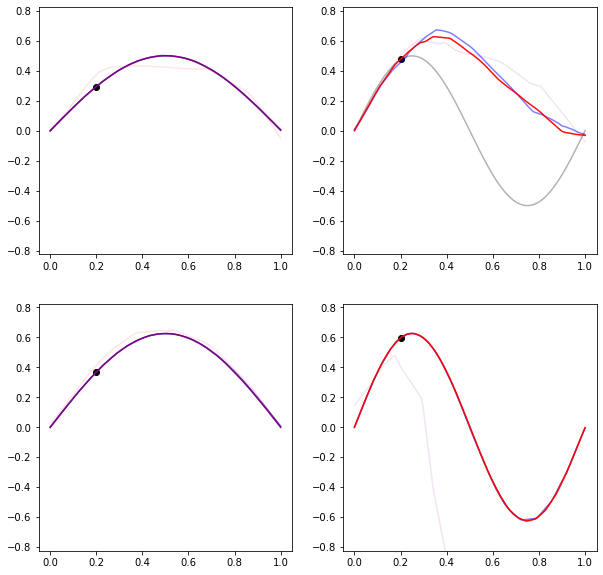

In [11]:
from matplotlib.lines import Line2D

plt_y_lim = torch.max(y) + 0.2

rows, cols = torch.ceil(torch.sqrt(torch.tensor(batch_size))).int(), torch.floor(torch.sqrt(torch.tensor(batch_size))).int()
fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
for i in range(rows):
    for j in range(cols):
        ind = i*cols+j

        axs[i, j].scatter(x[ind, test_ind, 0], y[ind, test_ind, 0], c='k')
        axs[i, j].set_ylim((-plt_y_lim, plt_y_lim))
        axs[i, j].plot(torch.linspace(0, 1, 200), y[ind], 'k', alpha=0.3)
        axs[i, j].plot(torch.linspace(0, 1, 200), pred_cnp[ind,:,0], 'b', alpha=0.5)
        for k in range(gate.shape[-1]):
            axs[i, j].plot(torch.linspace(0, 1, 200), pred_wta[k,ind,:,0], colors[k%batch_size], alpha=max(0.1, gate[ind, 0, k].item()))
        

In [27]:
rr = torch.cat((torch.cat((torch.tensor(y[0, 80, :]), torch.tensor(y[0, 120, :])), dim=0).unsqueeze(0), torch.cat((torch.tensor(y[1, 80, :]), torch.tensor(y[1, 120, :])), dim=0).unsqueeze(0)), dim=0).unsqueeze(-1)
# print(rr.shape)  # 2-2-1
wta.loss(pred_wta, gate.squeeze(1), rr)

/tmp/ipykernel_8279/1920264534.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rr = torch.cat((torch.cat((torch.tensor(y[0, 80, :]), torch.tensor(y[0, 120, :])), dim=0).unsqueeze(0), torch.cat((torch.tensor(y[1, 80, :]), torch.tensor(y[1, 120, :])), dim=0).unsqueeze(0)), dim=0).unsqueeze(-1)


(tensor(-44.9983), tensor(-4.7696))

In [7]:
# plt.ylim((-2.5, 2.5))

# plt.errorbar(torch.linspace(0, 1, 200), pred_cnp[0,:,0], yerr=pred_cnp[0,:,1])
# plt.plot(torch.linspace(0, 1, 200), pred_wta[1,0,:,0], 'k')

In [8]:
# plt.ylim((-2.5, 2.5))
# ind = 0
# plt.errorbar(torch.linspace(0, 1, 200), pred_wta[ind,0,:,0], yerr=pred_wta[ind,0,:,1])